## Overview
In the following example we will walk through how we can leverage the `clouddrift` library to do something interesting with the HURDAT2 dataset. Simply put, the HURDAT2 dataset is a dataset that contains storm track data (including other measurements such as pressure, wind speed, etc...) for storms recorded from 1852 - 2022 across both the Pacific and Atlantic ocean.

To get things in motion lets import `clouddrift` the library and load in some datasets.

In [69]:
import clouddrift

# Load HURDAT2 Storm Track Data dataset
storm_ds = clouddrift.datasets.hurdat2(decode_times=True)
storm_ds

<xarray.Dataset> Size: 13MB
Dimensions:                          (traj: 3143, obs: 84188)
Coordinates:
    id                               (traj) int64 25kB ...
    time                             (obs) datetime64[ns] 674kB ...
Dimensions without coordinates: traj, obs
Data variables: (12/23)
    basin                            (traj) <U2 25kB ...
    atcf_identifier                  (traj) <U8 101kB ...
    year                             (traj) int64 25kB ...
    rowsize                          (traj) int64 25kB ...
    record_identifier                (obs) <U1 337kB ...
    system_status                    (obs) <U2 674kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 674kB ...
    max_high_wind_radius_ne          (obs) float64 674kB ...
    max_high_wind_radius_se          (obs) float64 674kB ...
    max_high_wind_radius_sw          (obs) float64 674kB ...
    max_high_wind_radius_nw          (obs) float64 674kB ...
    max_sustained_wind_speed_radius  (obs) float64 674kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-03-24T21:39:49.842599
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [96]:
# Load GDP6H drifter dataset
import xarray as xr
fp = "aggregate_gdp6h_local.nc"
drifter_ds = clouddrift.adapters.gdp6h.to_raggedarray(n_random_id=5000).to_netcdf(fp)
drifter_ds = xr.load_dataset(fp)

Retrieving the number of obs: 100%|████████| 5000/5000 [00:47<00:00, 104.55it/s]
/home/ksantana/miniconda3/envs/hurdat2-get-started/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'WMO' has multiple fill values {-999999, '-999999'}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
Filling the Ragged Array:  23%|██▉          | 1146/5000 [00:48<02:52, 22.36it/s]/home/ksantana/sources/CloudDrift/hurdat2-get-started/clouddrift/adapters/gdp6h.py:185: RuntimeWarning: invalid value encountered in cast
  ds[var].data = ds[var].data.astype(target_dtype[var])
Filling the Ragged Array: 100%|█████████████| 5000/5000 [03:31<00:00, 23.68it/s]


In [97]:
drifter_ds

<xarray.Dataset> Size: 418MB
Dimensions:                (traj: 5000, obs: 8493477)
Coordinates:
    id                     (traj) int64 40kB 7902257 7702215 ... 300534063017480
    time                   (obs) datetime64[ns] 68MB 1979-06-07T12:00:00 ... ...
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    rowsize                (traj) int32 20kB 1518 1494 1682 1679 ... 73 89 70 54
    WMO                    (traj) int32 20kB 0 0 0 0 ... 5301668 2802070 5802067
    expno                  (traj) int32 20kB 73 73 73 73 ... 32212 31412 31412
    deploy_date            (traj) datetime64[ns] 40kB 1979-06-07 ... 2023-09-25
    deploy_lat             (traj) float32 20kB 5.0 -2.0 3.6 ... nan 5.02 3.0
    deploy_lon             (traj) float32 20kB -109.0 -109.5 ... -170.0 -170.0
    ...                     ...
    vn                     (obs) float32 34MB nan 0.01703 ... -0.5389 nan
    temp                   (obs) float32 34MB 28.06 nan 28.16 ... 30.87 30.74
    err_lat                (obs) float32 34MB 0.005711 0.01487 ... 0.001528
    err_lon                (obs) float32 34MB 0.003933 0.009688 ... 0.002127
    err_temp               (obs) float32 34MB 0.09003 0.1118 ... 0.04103 0.04103
    drogue_status          (obs) bool 8MB True True True True ... True True True
Attributes: (12/18)
    title:                Global Drifter Program drifting buoy collection
    history:              version September 2023. Metadata from dirall.dat an...
    Conventions:          CF-1.6
    time_coverage_start:  1979-06-07:00:00:00Z
    time_coverage_end:    2023-10-18:18:00:00Z
    date_created:         2024-03-27T00:17:00.668034
    ...                   ...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    institution:          NOAA Atlantic Oceanographic and Meteorological Labo...
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    summary:              Global Drifter Program six-hourly data
    doi:                  10.25921/7ntx-z961

Now lets say that we'd like to select a specific subset of this dataset; we can leverage the `subset` utility function provided through the `ragged` module which contains a library of helpful utility functions for working with the `RaggedArray` data structure.

As an example say you wanted a subset of the dataset for storms whose track lied within the Atlantic Ocean and was tracked between August and October of 2020. You can leverage the `subset` function to help you achieve this by first defining the criteria:

In [98]:
# import some helpful libraries
import numpy as np
from datetime import datetime

# Here the datasets variables are mapped to an (inclusive start and end) range
start_dt, end_dt = datetime(2020, 8, 1), datetime(2020, 10, 1)
criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        np.datetime64(int(start_dt.timestamp()), "s"),
        np.datetime64(int(end_dt.timestamp()), "s")
    )
)

Lets import the `subset` function and apply the criteria to both datasets. 

Here we need to provide the row dimensions alias which is `traj` in both datasets.

In [99]:
from clouddrift.ragged import subset

storm_subset_ds = subset(storm_ds, criteria, row_dim_name="traj")
storm_subset_ds

<xarray.Dataset> Size: 50kB
Dimensions:                          (traj: 14, obs: 313)
Coordinates:
    id                               (traj) int64 112B 3034 3035 ... 3055 3056
    time                             (obs) datetime64[ns] 3kB 2020-08-01T06:0...
Dimensions without coordinates: traj, obs
Data variables: (12/23)
    basin                            (traj) <U2 112B ...
    atcf_identifier                  (traj) <U8 448B ...
    year                             (traj) int64 112B ...
    rowsize                          (traj) int64 112B 19 4 24 7 ... 48 24 7 17
    record_identifier                (obs) <U1 1kB ...
    system_status                    (obs) <U2 3kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 3kB ...
    max_high_wind_radius_ne          (obs) float64 3kB ...
    max_high_wind_radius_se          (obs) float64 3kB ...
    max_high_wind_radius_sw          (obs) float64 3kB ...
    max_high_wind_radius_nw          (obs) float64 3kB ...
    max_sustained_wind_speed_radius  (obs) float64 3kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-03-24T21:39:49.842599
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [100]:
drifter_subset_ds = subset(drifter_ds, criteria, row_dim_name="traj")
drifter_subset_ds

<xarray.Dataset> Size: 503kB
Dimensions:                (traj: 46, obs: 9927)
Coordinates:
    id                     (traj) int64 368B 300234064015090 ... 300234066418770
    time                   (obs) datetime64[ns] 79kB 2020-08-01T06:00:00 ... ...
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    rowsize                (traj) int64 368B 244 244 241 244 244 ... 90 46 45 44
    WMO                    (traj) int32 184B 4101523 1501531 ... 4101789 4101785
    expno                  (traj) int32 184B 31312 21312 2222 ... 21312 21312
    deploy_date            (traj) datetime64[ns] 368B 2017-02-17 ... 2020-09-20
    deploy_lat             (traj) float32 184B 40.94 20.99 32.2 ... 28.99 29.72
    deploy_lon             (traj) float32 184B -67.15 -22.93 ... -62.46 -61.59
    ...                     ...
    vn                     (obs) float32 40kB -0.00767 -0.02605 ... -0.2055
    temp                   (obs) float32 40kB 25.47 25.64 26.09 ... 26.37 26.24
    err_lat                (obs) float32 40kB 0.001659 0.001659 ... 0.001595
    err_lon                (obs) float32 40kB 0.002471 0.002471 ... 0.002314
    err_temp               (obs) float32 40kB 0.03665 0.03665 ... 0.03261
    drogue_status          (obs) bool 10kB False False False ... True True True
Attributes: (12/18)
    title:                Global Drifter Program drifting buoy collection
    history:              version September 2023. Metadata from dirall.dat an...
    Conventions:          CF-1.6
    time_coverage_start:  1979-06-07:00:00:00Z
    time_coverage_end:    2023-10-18:18:00:00Z
    date_created:         2024-03-27T00:17:00.668034
    ...                   ...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    institution:          NOAA Atlantic Oceanographic and Meteorological Labo...
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    summary:              Global Drifter Program six-hourly data
    doi:                  10.25921/7ntx-z961

Lets generate an array we can utilize to determine the start and end index of each trajectories segment of the ragged array. We will do this for both the storm and drifter datasets.

In [101]:
storm_obs_range = np.cumsum(np.array([0, *storm_ds["rowsize"]]))
storm_obs_range

array([    0,    14,    15, ..., 84143, 84167, 84188])

In [102]:
drifter_obs_range  = np.cumsum(np.array([0, *drifter_ds["rowsize"]]))
drifter_obs_range

array([      0,    1518,    3012, ..., 8493353, 8493423, 8493477])

Lets see the storms and drifters which matched our criteria we will need them later for plotting

In [103]:
# ids that match the criteria
all_storms = storm_ds["id"].to_numpy().tolist()
selected_storms = storm_subset_ds["id"].to_numpy().tolist()
selected_storms

[3034,
 3035,
 3037,
 3039,
 3042,
 3046,
 3047,
 3049,
 3050,
 3051,
 3052,
 3054,
 3055,
 3056]

In [104]:
all_drifters = drifter_ds["id"].to_numpy().tolist()
selected_drifters = drifter_ds["id"].to_numpy().tolist()
selected_drifters

[7902257,
 7702215,
 7702212,
 7702254,
 7702801,
 7702814,
 7702235,
 7702229,
 7702826,
 7702822,
 7702835,
 7702173,
 7702199,
 7702177,
 7702180,
 7704417,
 7704407,
 7702186,
 7702084,
 7704419,
 7704421,
 7702088,
 7702247,
 7702282,
 7702284,
 7702097,
 7702099,
 8503082,
 7703088,
 8603083,
 7703138,
 7703130,
 7703148,
 7704820,
 8707960,
 8707936,
 8707939,
 8707932,
 7706852,
 7704829,
 8707961,
 8707947,
 8707993,
 8707992,
 8707928,
 8707970,
 8707943,
 8707987,
 8707957,
 8707981,
 8707983,
 8707952,
 8707994,
 7706859,
 7706867,
 7706857,
 7704590,
 7704592,
 7704596,
 7706882,
 7706889,
 7706888,
 7710581,
 7708004,
 7708007,
 7708006,
 7708017,
 7706890,
 7710590,
 7706191,
 7710582,
 7708000,
 7710826,
 7710827,
 7703153,
 8809731,
 7709739,
 7709744,
 7711123,
 7711117,
 7707925,
 7711016,
 7710814,
 7711022,
 7710820,
 7711127,
 7710597,
 7710585,
 7704604,
 7711033,
 7711043,
 7711020,
 7711135,
 7711023,
 7711017,
 7711125,
 7708720,
 7705252,
 7705253,
 7711047,


Now that we've selected the storms and drifters lets work on displaying their trajectories as an animation!

Lets begin by setting up the subplot/axes we'll be using to plot the trajectories. We can setup the map view to focus on the Atlantic Ocean showing us a bit of the east coast of North America.

(10.0, 80.0)

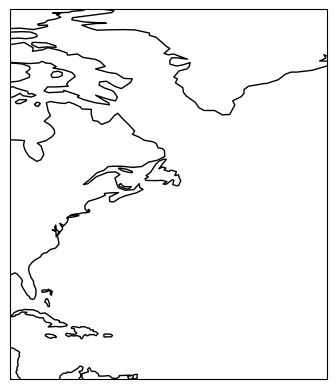

In [105]:
import cartopy.crs as ccrs  # cartopy for projecting our dataset onto different map projections
import matplotlib.pyplot as plt # is an standard plotting library
import matplotlib.animation as animation

fig = plt.figure()

ax = fig.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-5)))
ax.coastlines()

ax.set_xlim((-80, -20))
ax.set_ylim((10, 80))

Were going to iterate over both, the selected storms and the selected drifters. For each of the trajectories, we plot their starting point and store some data to be utilized for generating the animation.

In [106]:
lines = list()

for storm_id in selected_storms:
    idx = all_storms.index(storm_id)
    start, end = storm_obs_range[idx], storm_obs_range[idx+1]
    selected = slice(start, end)
    selected_lon, selected_lat = storm_ds["lon"].isel(obs=selected), storm_ds["lat"].isel(obs=selected)
    selected_lon, selected_lat = selected_lon.set_xindex("time"), selected_lat.set_xindex("time")
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="--", linewidth=2,
        transform=ccrs.PlateCarree()
    )
    lines.append((selected_lon, selected_lat, line[0]))

for drifter_id in selected_drifters:
    idx = all_drifters.index(drifter_id)
    start, end = drifter_obs_range[idx], drifter_obs_range[idx+1]
    selected = slice(start, end)
    selected_lon, selected_lat = drifter_ds["lon"].isel(obs=selected), drifter_ds["lat"].isel(obs=selected)
    selected_lon, selected_lat = selected_lon.set_xindex("time"), selected_lat.set_xindex("time")
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=1,
        transform=ccrs.PlateCarree()
    )
    lines.append((selected_lon, selected_lat, line[0]))


Lets take the start and end date we've used for the criteria and generate an range of values that each map uniquely to a frame.

In [111]:

import pandas as pd
frame_count = 100
daterange = pd.date_range(start_dt, end_dt, frame_count)

Lets now generate each frame by selecting the date associated to it which we utilize to update each trajectory with new observations

In [109]:
frames = list()
for idx, dt in enumerate(daterange):
    print(f"generating index: {idx}")
    frame_lines = dict()
    for d_lon, d_lat, d_line in lines:
        sel_d_lon = d_lon.sel(time=slice(start_dt, dt))
        sel_d_lat = d_lat.sel(time=slice(start_dt, dt))
        if len(sel_d_lat) > 0 and len(sel_d_lon) > 0:
            frame_lines[d_line] = (sel_d_lon, sel_d_lat)
    frames.append(frame_lines)

generating index: 0
generating index: 1
generating index: 2
generating index: 3
generating index: 4
generating index: 5
generating index: 6
generating index: 7
generating index: 8
generating index: 9
generating index: 10
generating index: 11
generating index: 12
generating index: 13
generating index: 14
generating index: 15
generating index: 16
generating index: 17
generating index: 18
generating index: 19
generating index: 20
generating index: 21
generating index: 22
generating index: 23
generating index: 24
generating index: 25
generating index: 26
generating index: 27
generating index: 28
generating index: 29
generating index: 30
generating index: 31
generating index: 32
generating index: 33
generating index: 34
generating index: 35
generating index: 36
generating index: 37
generating index: 38
generating index: 39
generating index: 40
generating index: 41
generating index: 42
generating index: 43
generating index: 44
generating index: 45
generating index: 46
generating index: 47
ge

We define an update function that, using the frame index, selects the frame and updates each trajectories longitude and latitude

In [110]:
def update(frame_idx):
    print(f"processing frame: {frame_idx}")
    frame = frames[frame_idx]
    updated_lines = frame.keys()
    for line in updated_lines:
        x_update, y_update = frame[line]
        line.set_xdata(x_update)
        line.set_ydata(y_update)
    return lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=frame_count, interval=250)
ani.save("storm_drifters.gif")
plt.show()

processing frame: 0
processing frame: 0
processing frame: 1
processing frame: 2
processing frame: 3
processing frame: 4
processing frame: 5
processing frame: 6
processing frame: 7
processing frame: 8
processing frame: 9
processing frame: 10
processing frame: 11
processing frame: 12
processing frame: 13
processing frame: 14
processing frame: 15
processing frame: 16
processing frame: 17
processing frame: 18
processing frame: 19
processing frame: 20
processing frame: 21
processing frame: 22
processing frame: 23
processing frame: 24
processing frame: 25
processing frame: 26
processing frame: 27
processing frame: 28
processing frame: 29
processing frame: 30
processing frame: 31
processing frame: 32
processing frame: 33
processing frame: 34
processing frame: 35
processing frame: 36
processing frame: 37
processing frame: 38
processing frame: 39
processing frame: 40
processing frame: 41
processing frame: 42
processing frame: 43
processing frame: 44
processing frame: 45
processing frame: 46
pro